In [1]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import SVHN
from sklearn.metrics import f1_score
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from torchvision.models import resnet18
import scipy
import tensorflow as tf
from PIL import Image as im
import cv2
import glob

In [2]:
import wandb
wandb.login()
wandb.init(project="Assignement 1 Q2", name="baseline")
wandb.config = {"learning_rate": 0.001 , "epochs": 5, "batch_size": 16}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: satyam20330 (nemesis-19). Use `wandb login --relogin` to force relogin


In [2]:
images = []
masks = []
mss = []

imgs_path = 'VOC/images/'
masks_path = 'VOC/masks/'

for img in sorted(os.listdir(imgs_path)):
    img = cv2.cvtColor(cv2.imread(imgs_path + img), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    images.append(img)

for mask in sorted(os.listdir(masks_path)):
    mask = cv2.cvtColor(cv2.imread(masks_path + mask), cv2.COLOR_BGR2RGB)
    mss.append(mask)
    mask = cv2.resize(mask, (256, 256))
    masks.append(mask)

In [3]:
transform_updt = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [4]:
cmap = [
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128)
]


In [5]:
dataset_size = len(images)
train_size = int(0.7 * dataset_size)
test_size = int(0.1 * dataset_size)
val_size = int(0.2 * dataset_size)

train_data = images[:train_size]
train_labels = masks[:train_size]
train_labels_o = mss[:train_size]
test_data = images[train_size:train_size + test_size]
test_labels = masks[train_size:train_size + test_size]
test_labels_o = mss[train_size:train_size + test_size]
val_data = images[train_size + test_size:]
val_labels = masks[train_size + test_size:]
val_labels_o = mss[train_size + test_size:]

class custom_data_loader(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __label__(img):
        label = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                for k in range(len(cmap)):
                    if (img[i][j] == cmap[k]).all():
                        label[i][j] = k
                        break
        return label

    def __getitem__(self, idx):
        img = transform_updt(self.X[idx])
        label = custom_data_loader.__label__(self.y[idx])
        return img, label

train_dataset = custom_data_loader(train_data, train_labels)
test_dataset = custom_data_loader(test_data, test_labels)
val_dataset = custom_data_loader(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

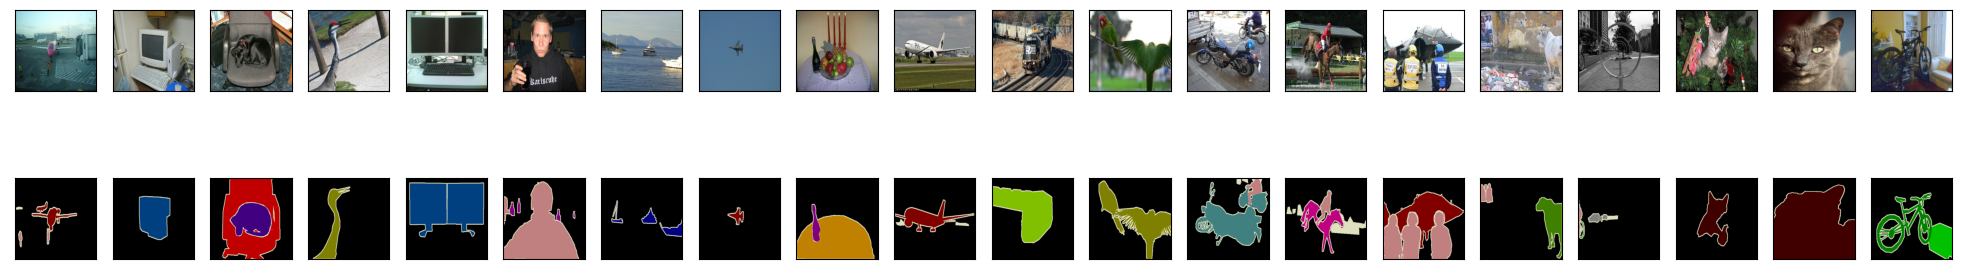

In [92]:
def plot_images(images, masks):
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx])
        fig.add_subplot(2, 20, idx+1+20, xticks=[], yticks=[])
        plt.imshow(masks[idx])
    plt.show()

plot_images(train_data, train_labels)

In [79]:
classes = { 
            0: 'background',
            1280000: 'aeroplane', 
            12800: 'bicycle', 
            1292800: 'bird', 
            128: 'boat', 
            1280128: 'bottle', 
            12928: 'bus', 
            1292928: 'car', 
            640000: 'cat', 
            1920000: 'chair', 
            652800: 'cow', 
            1932800: 'dining table', 
            640128: 'dog', 
            1920128: 'horse', 
            652928: 'motorbike', 
            1932928: 'person', 
            6400: 'potted plant', 
            1286400: 'sheep', 
            19200: 'sofa', 
            1299200: 'train', 
            6528: 'tv/monitor'
          }

class_count = {cls: 0 for cls in classes.values()}

for imm in train_labels_o:
  added = set()
  for color in imm:
    for pixel in color:
      val = pixel[0] * 10000 + pixel[1] * 100 + pixel[2]
      if val in classes and val not in added:
          class_count[classes[val]] += 1
          added.add(val)

print(class_count)

{'background': 1022, 'aeroplane': 65, 'bicycle': 47, 'bird': 69, 'boat': 62, 'bottle': 57, 'bus': 52, 'car': 88, 'cat': 81, 'chair': 96, 'cow': 46, 'dining table': 65, 'dog': 66, 'horse': 54, 'motorbike': 64, 'person': 307, 'potted plant': 60, 'sheep': 39, 'sofa': 55, 'train': 57, 'tv/monitor': 65}


In [107]:
class_count = {cls: 0 for cls in classes.values()}

for imm in val_labels_o:
  added = set()
  for color in imm:
    for pixel in color:
      val = pixel[0] * 10000 + pixel[1] * 100 + pixel[2]
      if val in classes and val not in added:
          class_count[classes[val]] += 1
          added.add(val)

print(class_count)

{'background': 292, 'aeroplane': 17, 'bicycle': 9, 'bird': 32, 'boat': 11, 'bottle': 21, 'bus': 19, 'car': 29, 'cat': 28, 'chair': 33, 'cow': 9, 'dining table': 9, 'dog': 30, 'horse': 10, 'motorbike': 13, 'person': 96, 'potted plant': 15, 'sheep': 15, 'sofa': 27, 'train': 19, 'tv/monitor': 13}


In [6]:
g = torch.Generator()
g.manual_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [7]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model = model.to(device)

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=000.1)

C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Satyam Arora\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

wandb.watch(model, log="all")

for epoch in range(3):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs['out']
        loss = criterian(outputs.to(device), labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_acc_epoch.append((predicted == labels).sum().item() / (labels.shape[0] * labels.shape[1] * labels.shape[2]))
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    model.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    n_samples = 0
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs['out']
        loss = criterian(outputs, labels.type(torch.LongTensor).to(device))
        val_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        val_acc_epoch.append((predicted == labels).sum().item() / (labels.shape[0] * labels.shape[1] * labels.shape[2]))
    val_loss.append(np.mean(val_loss_epoch))
    val_acc.append(np.mean(val_acc_epoch))

    wandb.log({"Train Loss": train_loss[-1], "Train Acc": train_acc[-1], "Val Loss": val_loss[-1], "Val Acc": val_acc[-1]})
    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

Epoch: 0, Train Loss: 1.6120668649673462, Train Acc: 0.7603588104248047, Val Loss: 0.7674166440963745, Val Acc: 0.8155167770385742
Epoch: 1, Train Loss: 0.9674166440963745, Train Acc: 0.8333403015136719, Val Loss: 0.7123533364456567, Val Acc: 0.8356294066436176
Epoch: 2, Train Loss: 0.7153335635443212, Train Acc: 0.8656114262289176, Val Loss: 0.7025620393599952, Val Acc: 0.8462440346873695
Epoch: 3, Train Loss: 0.6077820893566327, Train Acc: 0.8823456736838989, Val Loss: 0.6893623667566771, Val Acc: 0.8520098984540701
Epoch: 4, Train Loss: 0.5562776730645812, Train Acc: 0.8962440346873695, Val Loss: 0.6867720933461135, Val Acc: 0.8567708995469556


In [15]:
from collections import defaultdict

cmap = {
    0 : 'background',
    1 : 'aeroplane',
    2 : 'bicycle',
    3 : 'bird',
    4 : 'boat',
    5 : 'bottle',
    6 : 'bus',
    7 : 'car',
    8 : 'cat',
    9 : 'chair',
    10 : 'cow',
    11 : 'dining table',
    12 : 'dog',
    13 : 'horse',
    14 : 'motorbike',
    15 : 'person',
    16 : 'pottedplant',
    17 : 'sheep',
    18 : 'sofa',
    19 : 'train',
    20 : 'tv/monitor'
}

class_acc = defaultdict(int)
num_total = defaultdict(int)
cf_mat = np.zeros((21, 21))
y_true = []
y_pred = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)['out']
        _, prediction = torch.max(outputs, 1)
        y_true.append(labels.cpu().numpy().flatten())
        y_pred.append(prediction.cpu().numpy().flatten())
        labels = labels.squeeze(dim=1)
        num_total.update({c: (labels == c).sum().item() for c in range(21)})
        for c in range(21):
            match = (prediction == c) & (labels == c)
            class_acc[c] += match.sum().item()
            for d in range(21):
                cf_mat[c, d] += ((prediction == d) & (labels == c)).sum().item()

print("Classwise Accuracy")

for c in range(21):
    accuracy = class_acc[c] / num_total[c]
    print(f"{cmap[c]} : {accuracy:.3f}")

background : 0.917
aeroplane : 0.785
bicycle : 0.636
bird : 0.519
boat : 0.791
bottle : 0.487
bus : 0.886
car : 0.845
cat : 0.934
chair : 0.247
cow : 0.527
dining table : 0.176
dog : 0.651
horse : 0.697
motorbike : 0.684
person : 0.784
pottedplant : 0.673
sheep : 0.528
sofa : 0.429
train : 0.661
tv/monitor : 0.875


In [1]:
print("Classwise Precision, Recall, F1 Score")
for i in range(21):
    class_name = cmap[i]
    true_positives = cf_mat[i, i]
    false_positives = np.sum(cf_mat[:, i]) - true_positives
    false_negatives = np.sum(cf_mat[i, :]) - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"{class_name} : {precision}, {recall}, {f1_score}")

average_precision = np.trace(cf_mat) / np.sum(cf_mat)
print(f"Average precision is {average_precision}")

Classwise Precision, Recall, F1 Score
background : 0.866949965337834, 0.9224739431100792, 0.8938774226403963
aeroplane : 0.9261404603024741, 0.748038462863012, 0.8276534126474434
bicycle : 0.21714026632123417, 0.3353042747189058, 0.26370426430723
bird : 0.5469451603785396, 0.46613447511766656, 0.5033652648811797
boat : 0.570740566318451, 0.82186384588213, 0.6736825754264638
bottle : 0.33444756630508403, 0.17731456855208302, 0.23229264610448005
bus : 0.8898470633279359, 0.9079304826884811, 0.8988183264428788
car : 0.8809420673879012, 0.8828364763838564, 0.8818828264229031
cat : 0.5109426643857144, 0.9679384642919705, 0.6688476264837438
chair : 0.0935413613609993, 0.028135483735631543, 0.04328264560065826
cow : 0.34354996938702003, 0.4173247329302202, 0.3769322649759286
diningtable : 0.234441462331197, 0.1130233479593672, 0.15251385264820266
dog : 0.5595444653873095, 0.6732344150325782, 0.6111512264804141
horse : 0.8525433673338615, 0.6492374353846914, 0.7371209264494872
motorbike : 0.83

In [20]:
print("Classwise IoU")
for i in range(21):
  intersecion = ((y_true==i)&(y_pred==i)).sum()
  union = ((y_true==i)|(y_pred==i)).sum()
  print(f"{cmap[i]} : {intersecion / union}")

Classwise IoU
background 0.8580899446038184
aeroplane 0.3119924841275065
bicycle 0.12252515826376453
bird 0.07809832410020556
boat 0.14366354306113344
bottla 0.031933172479344886
bus 0.45860006504684164
car 0.36725458732535265
cat 0.48072117379489787
chair 0.024459536697710386
cow 0.253770523355592
dining table 0.2028725455475544
dog 0.18122470011309896
horse 0.22818548746766568
motorbike 0.320966427036241
person 0.46834559493628936
pottedplant 0.003385942875866965
sheep 0.23091454232548134
sofa 0.16592905642533637
train 0.16293799639591536
tv/monitor 0.0973028684241087


In [ ]:
transform_new = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

new_images = []
new_masks = []
new_mss = []

imgs_path = 'VOC/images/'
masks_path = 'VOC/masks/'

for img in sorted(os.listdir(imgs_path)):
    img = cv2.cvtColor(cv2.imread(imgs_path + img), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    new_images.append(img)

for mask in sorted(os.listdir(masks_path)):
    mask = cv2.cvtColor(cv2.imread(masks_path + mask), cv2.COLOR_BGR2RGB)
    new_mss.append(mask)
    mask = cv2.resize(mask, (256, 256))
    new_masks.append(mask)

cmap = [
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128)
]

dataset_size = len(new_images)
train_size = int(0.7 * dataset_size)

new_train_data = new_images[:train_size]
new_train_labels = new_masks[:train_size]
new_train_labels_o = new_mss[:train_size]

class custom_data_loader(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __label__(img):
        label = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                for k in range(len(cmap)):
                    if (img[i][j] == cmap[k]).all():
                        label[i][j] = k
                        break
        return label

    def __getitem__(self, idx):
        img = transform_updt(self.X[idx])
        label = custom_data_loader.__label__(self.y[idx])
        return img, label

train_data_n = np.concatenate((train_data, new_train_data))
train_labels_n = np.concatenate((train_labels, new_train_labels))
train_labels_n_o = np.concatenate((train_labels_o, new_train_labels_o))

train_dataset_n = custom_data_loader(train_data_n, train_labels_n)

train_loader_n = DataLoader(train_dataset_n, batch_size=16, shuffle=True)

In [ ]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model = model.to(device)

criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=000.1)

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

wandb.watch(model, log="all")

for epoch in range(3):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    for i, (images, labels) in enumerate(train_loader_n):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs['out']
        loss = criterian(outputs.to(device), labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        train_acc_epoch.append((predicted == labels).sum().item() / (labels.shape[0] * labels.shape[1] * labels.shape[2]))
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    model.eval()
    val_loss_epoch = []
    val_acc_epoch = []
    n_samples = 0
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs['out']
        loss = criterian(outputs, labels.type(torch.LongTensor).to(device))
        val_loss_epoch.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        val_acc_epoch.append((predicted == labels).sum().item() / (labels.shape[0] * labels.shape[1] * labels.shape[2]))
    val_loss.append(np.mean(val_loss_epoch))
    val_acc.append(np.mean(val_acc_epoch))

    wandb.log({"Train Loss": train_loss[-1], "Train Acc": train_acc[-1], "Val Loss": val_loss[-1], "Val Acc": val_acc[-1]})
    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))

In [ ]:
from collections import defaultdict

cmap = {
    0 : 'background',
    1 : 'aeroplane',
    2 : 'bicycle',
    3 : 'bird',
    4 : 'boat',
    5 : 'bottle',
    6 : 'bus',
    7 : 'car',
    8 : 'cat',
    9 : 'chair',
    10 : 'cow',
    11 : 'dining table',
    12 : 'dog',
    13 : 'horse',
    14 : 'motorbike',
    15 : 'person',
    16 : 'pottedplant',
    17 : 'sheep',
    18 : 'sofa',
    19 : 'train',
    20 : 'tv/monitor'
}

class_acc = defaultdict(int)
num_total = defaultdict(int)
cf_mat = np.zeros((21, 21))
y_true = []
y_pred = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)['out']
        _, prediction = torch.max(outputs, 1)
        y_true.append(labels.cpu().numpy().flatten())
        y_pred.append(prediction.cpu().numpy().flatten())
        labels = labels.squeeze(dim=1)
        num_total.update({c: (labels == c).sum().item() for c in range(21)})
        for c in range(21):
            match = (prediction == c) & (labels == c)
            class_acc[c] += match.sum().item()
            for d in range(21):
                cf_mat[c, d] += ((prediction == d) & (labels == c)).sum().item()

print("Classwise Accuracy")

for c in range(21):
    accuracy = class_acc[c] / num_total[c]
    print(f"{cmap[c]} : {accuracy:.3f}")

In [ ]:
print("Classwise Precision, Recall, F1 Score")
for i in range(21):
    class_name = cmap[i]
    true_positives = cf_mat[i, i]
    false_positives = np.sum(cf_mat[:, i]) - true_positives
    false_negatives = np.sum(cf_mat[i, :]) - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"{class_name} : {precision}, {recall}, {f1_score}")

average_precision = np.trace(cf_mat) / np.sum(cf_mat)
print(f"Average precision is {average_precision}")

In [ ]:
print("Classwise IoU")
for i in range(21):
  intersecion = ((y_true==i)&(y_pred==i)).sum()
  union = ((y_true==i)|(y_pred==i)).sum()
  print(f"{cmap[i]} : {intersecion / union}")